In [1]:
import pandas as pd
from matplotlib import pyplot as plt
#!pip install matplotlib
import seaborn as sns

C:\Users\PC-Usuario\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\PC-Usuario\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\PC-Usuario\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\PC-Usuario\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
lpop = pd.read_stata('ARG_2021_LAPOP_AmericasBarometer_v1.2_w.dta',convert_categoricals=False)
gpt = pd.read_csv('respuestas_gpt35_turbo')
cohere = pd.read_csv('respuestas_cohere.csv')
bard = pd.read_csv('respuestas_bard.csv')

In [3]:
# Crea un StataReader para leer los metadatos
reader = pd.io.stata.StataReader('ARG_2021_LAPOP_AmericasBarometer_v1.2_w.dta')

In [4]:
import pickle
with open(r"respuestas.pickle", "rb") as input_file:
    respuestas = pickle.load(input_file)
with open(r"preguntas_seleccionadas.pickle", "rb") as input_file:
    preguntas_seleccionadas = pickle.load(input_file)

In [5]:
lpop['gpt_distance'] = 1

/tmp/ipykernel_40439/1189577783.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['gpt_distance'] = 1


In [6]:
bard[bard['Pregunta']==list(preguntas_seleccionadas.keys())[1]]['Respuesta'].values[0]

2

In [7]:
lpop.shape

(3011, 249)

In [8]:
sum(lpop['wt'])

3010.999830670655

In [5]:
import math
def calculate_distance(responde,llm):    
    result = 0
    num_pregs = 0
    for pregunta in list(preguntas_seleccionadas.keys()):
        if((pregunta.lower() in responde.keys()) and (not math.isnan(responde[pregunta.lower()])) and (pregunta in list(llm['Pregunta'])) 
           and(llm[llm['Pregunta']== pregunta]['Respuesta'].values[0] < 10) ):
            
            result = result + (abs(responde[pregunta.lower()]-llm[llm['Pregunta']== pregunta]['Respuesta'].values[0]))
            num_pregs = num_pregs + 1
    if(num_pregs == 0):
        result = -1
        norm_result = -1
    else:
        norm_result = result/num_pregs
    
    return(result, num_pregs, norm_result)
calculate_distance(lpop.loc[0],bard)

(31.0, 18, 1.7222222222222223)

In [6]:
lpop['cohere_results'] = lpop.apply(lambda x: calculate_distance(x, cohere), axis=1)
lpop[['cohere_distance', 'cohere_num_preg', 'cohere_distance_norm']] = pd.DataFrame(lpop['cohere_results'].tolist(), index=lpop.index)

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\686401638.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['cohere_results'] = lpop.apply(lambda x: calculate_distance(x, cohere), axis=1)
C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\686401638.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop[['cohere_distance', 'cohere_num_preg', 'cohere_distance_norm']] = pd.DataFrame(lpop['cohere_results'].tolist(), index=lpop.index)
C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\686401638.py:2: Performan

In [7]:
lpop = lpop.sort_values(by='cohere_distance_norm', ascending=True)

# 2. Calcular el número de filas que representa el 10%
num_rows_10_percent = int(len(lpop) * 0.1)

# 3. Seleccionar las primeras filas correspondientes al 10%
lpop_cohere = lpop[(lpop['cohere_num_preg']>5)].head(num_rows_10_percent)

In [8]:
lpop_cohere.shape[0]/lpop.shape[0]

0.09996678844237794

In [9]:
lpop_cohere.shape[0]

301

In [10]:
preguntas_gpt = []
for idx, responde in lpop_cohere.iterrows():
    for pregunta in list(preguntas_seleccionadas.keys()):
            if((pregunta.lower() in responde.keys()) and (not math.isnan(responde[pregunta.lower()])) and (pregunta in list(cohere['Pregunta'])) 
               and(cohere[cohere['Pregunta']== pregunta]['Respuesta'].values[0] < 10) ):
                preguntas_gpt.append(pregunta.lower())

In [11]:
df_preg = pd.DataFrame(data={'preguntas':preguntas_gpt})
value_counts = df_preg['preguntas'].value_counts()
for pregunta, count in value_counts.items():
    print('-',preguntas_seleccionadas[pregunta.upper()],': ',respuestas[pregunta.upper()][cohere[cohere['Pregunta']== pregunta.upper()]['Respuesta'].values[0]], count)
    print(" ")

- ¿Cree usted que cuando el país enfrenta momentos muy difíciles, se justifica que el presidente del país cierre el Congreso y gobierne sin Congreso? :  No se justificaría 296
 
- ¿Hasta qué punto está de acuerdo o en desacuerdo con la siguiente afirmación? Si la Corte Suprema de Justicia de Argentina comenzara a tomar muchas decisiones que van en contra de lo que piensa la mayoría de la gente, lo mejor sería eliminar la Corte Suprema de Justicia. Usted está… :  En desacuerdo 289
 
- Alguna gente dice que en ciertas circunstancias se justificaría que los militares de este país tomen el poder por un golpe de Estado. En su opinión se justificaría que hubiera un golpe de Estado por los militares Cuando hay una emergencia de salud pública como el coronavirus? :  No se justificaría 163
 
- ¿Cree usted que cuando hay mucha violencia se justifica que el presidente posponga las elecciones? :  No se justificaría 153
 
- Le mencionaré algunas cosas que pueden suceder durante las elecciones y le 

## Edad

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


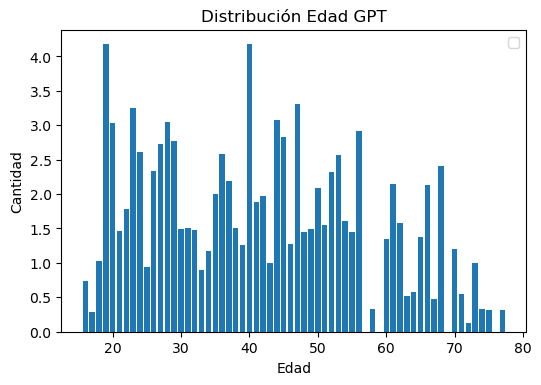

In [12]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_cohere.groupby('q2')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.title("Distribución Edad GPT")
plt.ylabel("Cantidad")
plt.xlabel("Edad")

plt.legend()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


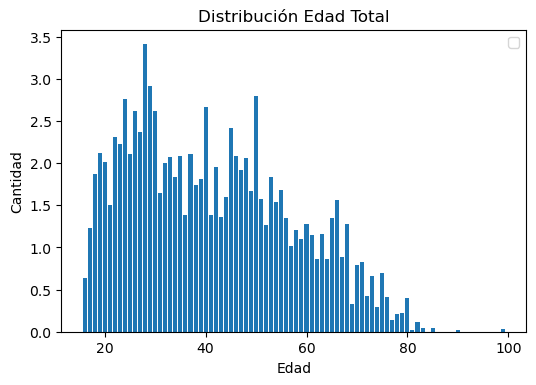

In [13]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade = lpop.groupby('q2')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.title("Distribución Edad Total")
plt.ylabel("Cantidad")
plt.xlabel("Edad")

plt.legend()
plt.show()



In [14]:
from scipy.stats import ttest_ind

# Realizar la prueba t
estadistico, p_valor = ttest_ind(list(users_per_grade.values), list(users_per_grade_gpt.values))

print("Estadístico de prueba t:", estadistico)
print("Valor p:", p_valor)

Estadístico de prueba t: 11.325688618754269
Valor p: 5.524146856835556e-21


In [15]:
users_per_grade_gpt.mean()

4.9331937

In [16]:
users_per_grade_gpt.median()

4.31700325012207

In [17]:
users_per_grade.mean()

42.408443

In [18]:
users_per_grade.median()

41.71773147583008

## Género

In [19]:
lpop_cohere['q1tb_label'] = lpop_cohere['q1tb'].apply(lambda x: reader.value_labels()['q1tb_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\1291482559.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop_cohere['q1tb_label'] = lpop_cohere['q1tb'].apply(lambda x: reader.value_labels()['q1tb_esp'][x])


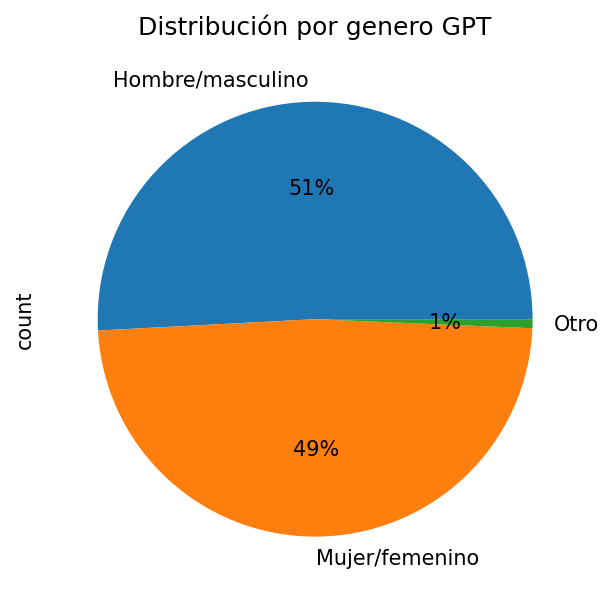

In [20]:
plt.figure(figsize=(6.4, 4.8), dpi=150)
lpop_cohere['q1tb_label'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)
plt.title('Distribución por genero GPT')
plt.savefig('genero GPT.png')
plt.show()

In [21]:
lpop['q1tb_label'] = lpop['q1tb'].apply(lambda x: reader.value_labels()['q1tb_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\1756115608.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['q1tb_label'] = lpop['q1tb'].apply(lambda x: reader.value_labels()['q1tb_esp'][x])


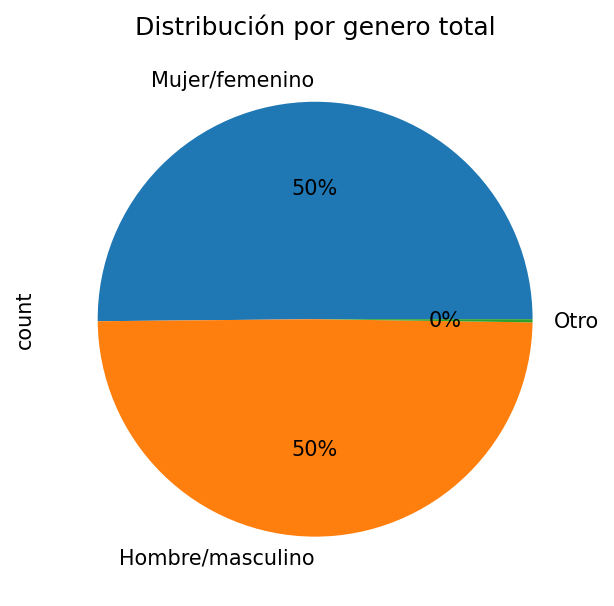

In [22]:
plt.figure(figsize=(6.4, 4.8), dpi=150)
lpop['q1tb_label'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)
plt.title('Distribución por genero total')
plt.savefig('genero otal.png')
plt.show()

In [23]:
from statsmodels.stats.proportion import proportions_ztest

# tamaños de las muestras
n_total = lpop.shape[0]# pon aquí el tamaño de la muestra total
n_submuestra = lpop_cohere.shape[0]# pon aquí el tamaño de la submuestra

# número de éxitos (en este caso, mujeres) en cada muestra
count_total = n_total * 0.50  # 50% de la muestra total son mujeres
count_submuestra = n_submuestra * 0.51  # 55% de la submuestra son mujeres

# realizamos el test de proporciones
z_stat, p_value = proportions_ztest([count_submuestra, count_total], [n_submuestra, n_total])

print('Z-statistic:', z_stat)
print('p-value:', p_value)

Z-statistic: 0.33084469448428805
p-value: 0.7407617988472119


## Provincia

In [24]:
import math
lpop_cohere['prov1t_label'] = lpop_cohere['prov1t'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['prov1t_eng'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\2688560247.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop_cohere['prov1t_label'] = lpop_cohere['prov1t'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['prov1t_eng'][x])


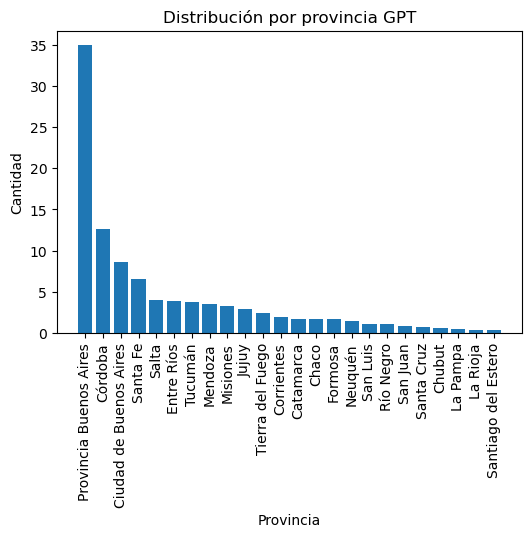

In [25]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_cohere.groupby('prov1t_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Provincia")
plt.title('Distribución por provincia GPT')
plt.xticks(rotation=90)
plt.show()



In [26]:
import math
lpop['prov1t_label'] = lpop['prov1t'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['prov1t_eng'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\699261593.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['prov1t_label'] = lpop['prov1t'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['prov1t_eng'][x])


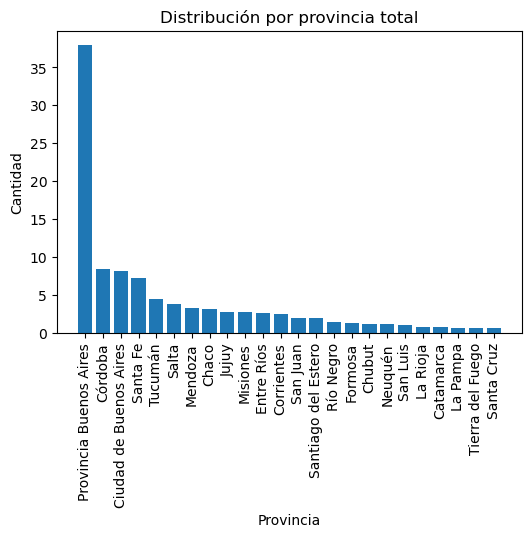

In [27]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('prov1t_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Provincia")
plt.title('Distribución por provincia total')
plt.xticks(rotation=90)
plt.show()



In [28]:
from scipy.stats import chi2_contingency


# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([list(users_per_grade_gpt.values), list(users_per_grade_total.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 34.50675109085431
Valor p: 0.05817722749001305


## Urbanización

In [29]:

lpop_cohere['ur1new_label'] = lpop_cohere['ur1new'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['ur1new_esp'][x])
lpop['ur1new_label'] = lpop['ur1new'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['ur1new_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\3492639426.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop_cohere['ur1new_label'] = lpop_cohere['ur1new'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['ur1new_esp'][x])
C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\3492639426.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['ur1new_label'] = lpop['ur1new'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['ur1new_esp'][x])


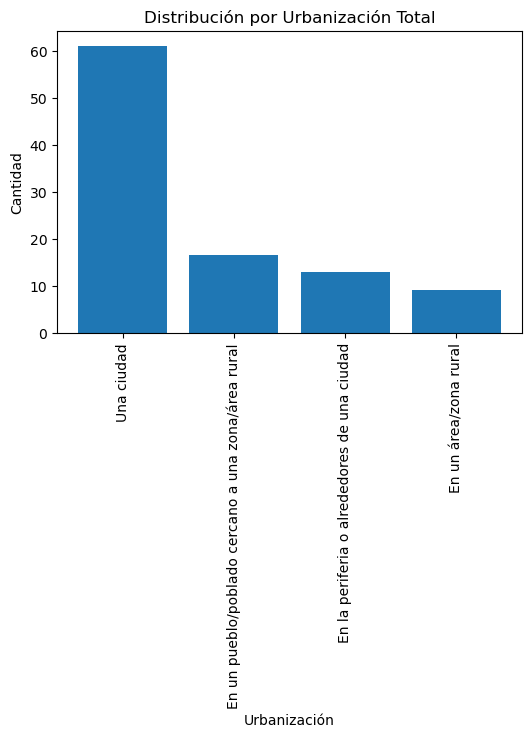

In [30]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('ur1new_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Urbanización")
plt.title('Distribución por Urbanización Total')
plt.xticks(rotation=90)
plt.show()


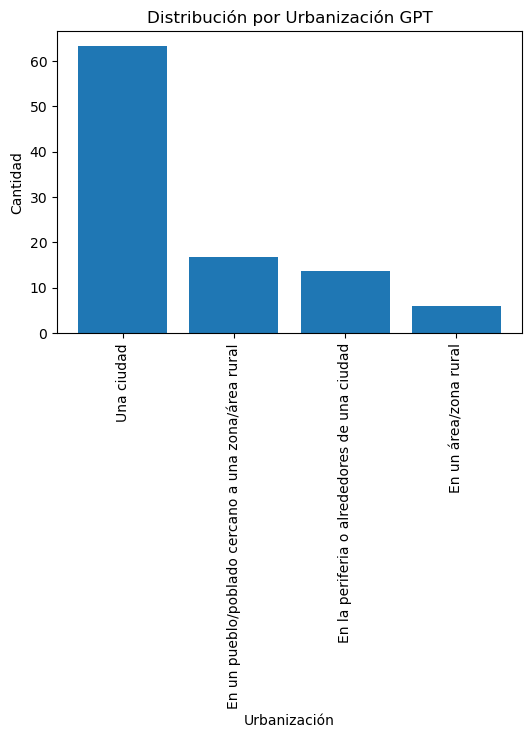

In [31]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_cohere.groupby('ur1new_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Urbanización")
plt.title('Distribución por Urbanización GPT')
plt.xticks(rotation=90)
plt.show()


In [32]:
from scipy.stats import chi2_contingency


# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([list(users_per_grade_gpt.values), list(users_per_grade_total.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 3.0204888432644768
Valor p: 0.38847697461411607


## Nivel educativo

In [33]:

lpop_cohere['edr_label'] = lpop_cohere['edr'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['edr_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\460240200.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop_cohere['edr_label'] = lpop_cohere['edr'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['edr_esp'][x])


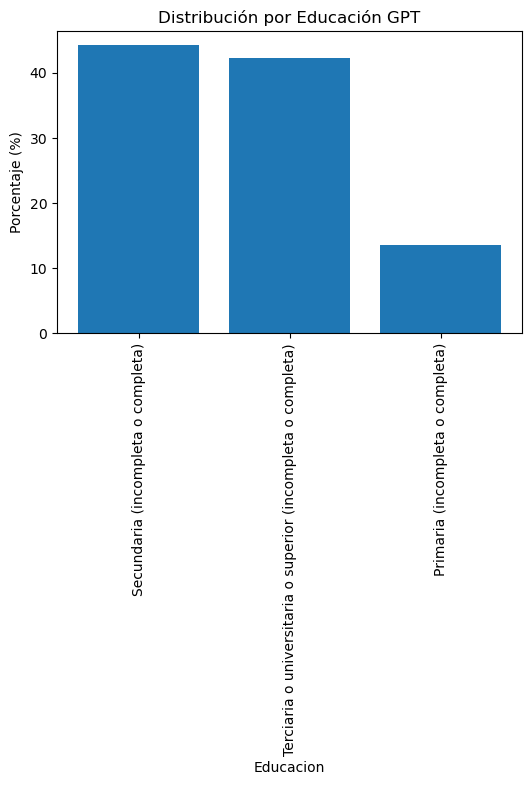

In [34]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_cohere.groupby('edr_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Educacion")
plt.title('Distribución por Educación GPT')
plt.xticks(rotation=90)
plt.show()

In [35]:
users_per_grade_pct_sorted

edr_label
Secundaria (incompleta o completa)                              44.184174
Terciaria o universitaria o superior (incompleta o completa)    42.292389
Primaria (incompleta o completa)                                13.523436
Name: wt, dtype: float32

In [41]:
users_per_grade_pct_sorted_total

edr_label
Secundaria (incompleta o completa)                              43.618168
Terciaria o universitaria o superior (incompleta o completa)    33.687271
Primaria (incompleta o completa)                                21.239805
Ninguna                                                          1.454757
Name: wt, dtype: float32

In [39]:
lpop['edr_label'] = lpop['edr'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['edr_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\3698008637.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['edr_label'] = lpop['edr'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['edr_esp'][x])


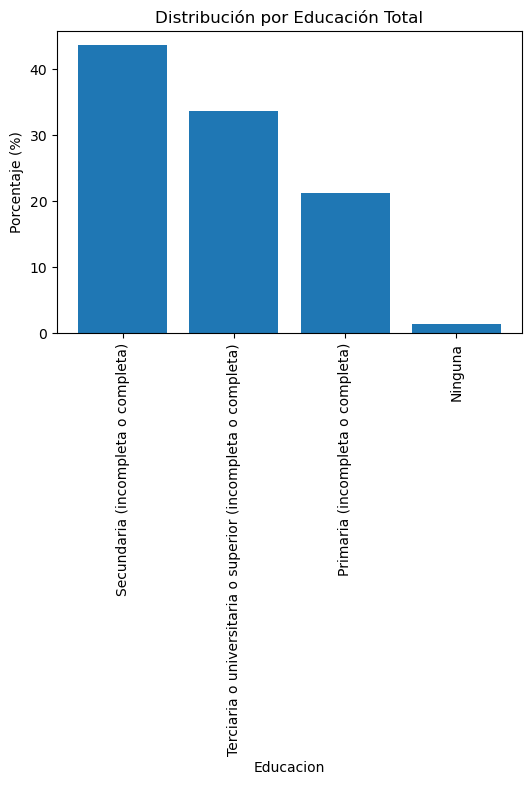

In [40]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade = lpop.groupby('edr_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted_total = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted_total.index, users_per_grade_pct_sorted_total.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Educacion")
plt.title('Distribución por Educación Total')
plt.xticks(rotation=90)
plt.show()

In [44]:
list(users_per_grade_gpt.values)+[0]

[38.585583, 126.06798, 120.67026, 0]

In [45]:
list(users_per_grade.values)

[43.79108, 639.3603, 1312.9934, 1014.05365]

In [46]:
from scipy.stats import chi2_contingency

# Datos de ejemplo
submuestra = [1, 2, 3, 2, 1, 1, 4, 3, 2, 3, 1, 4, 4, 4, 3]

# Contar las frecuencias observadas
frecuencias_obs = [submuestra.count(i) for i in range(1, 5)]

# Frecuencias esperadas uniformes (asumiendo igual probabilidad para cada categoría)
frecuencias_esp = [len(submuestra) // 4] * 4

# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)+[0]])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 307.15674629625147
Valor p: 2.8105231703958644e-66


## Ingresos

In [47]:
lpop_cohere['q10newt_label'] = lpop_cohere['q10newt'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['q10newt_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\107232878.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop_cohere['q10newt_label'] = lpop_cohere['q10newt'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['q10newt_esp'][x])


In [61]:
lpop_cohere['q10newt'].isnull().sum()/lpop_cohere.shape[0]

1.0

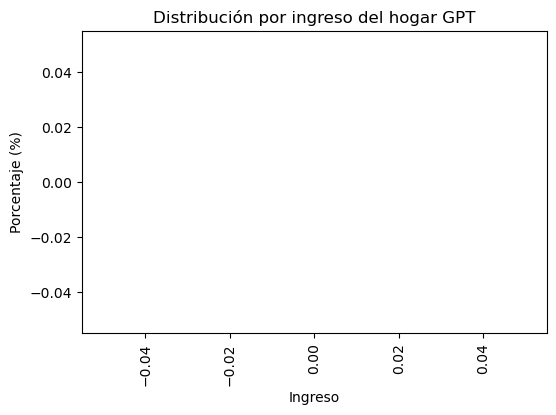

In [48]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade = lpop_cohere.groupby('q10newt_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Ingreso")
plt.title('Distribución por ingreso del hogar GPT')
plt.xticks(rotation=90)
plt.show()

In [55]:
users_per_grade_pct_sorted

Series([], Name: wt, dtype: float32)

In [74]:
lpop['q10newt_label'] = lpop['q10newt'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['q10newt_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_4924\3273679197.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['q10newt_label'] = lpop['q10newt'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['q10newt_esp'][x])


In [78]:
users_per_grade

Series([], Name: wt, dtype: float32)

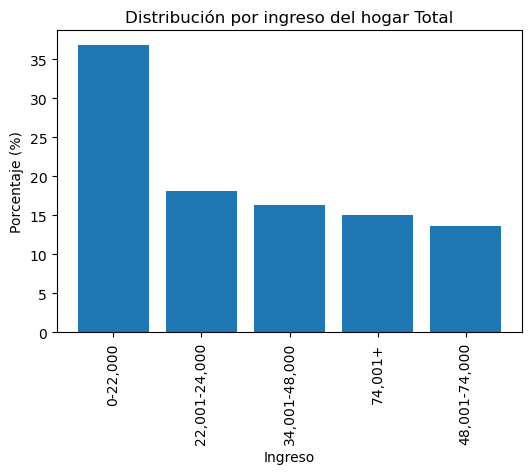

In [76]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('q10newt_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Ingreso")
plt.title('Distribución por ingreso del hogar Total')
plt.xticks(rotation=90)
plt.show()

In [77]:
from scipy.stats import chi2_contingency

# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([ list(users_per_grade_total.values),list(users_per_grade.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

## Conocimiento de política

In [50]:
lpop_cohere['conocim_label'] = lpop_cohere['conocim'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['conocim_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\3410860138.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop_cohere['conocim_label'] = lpop_cohere['conocim'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['conocim_esp'][x])


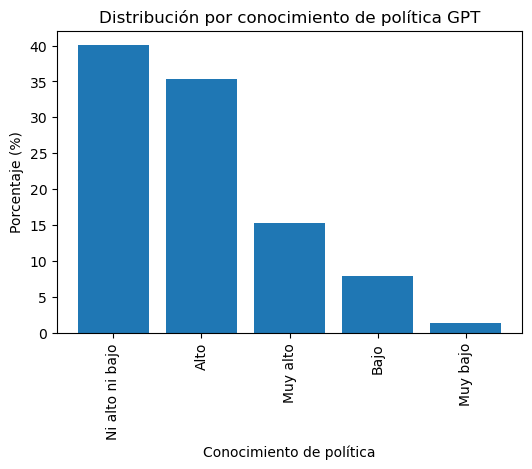

In [51]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade = lpop_cohere.groupby('conocim_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Conocimiento de política")
plt.title('Distribución por conocimiento de política GPT')
plt.xticks(rotation=90)
plt.show()

In [52]:
users_per_grade_pct_sorted

conocim_label
Ni alto ni bajo    40.067997
Alto               35.294907
Muy alto           15.271070
Bajo                7.956942
Muy bajo            1.409083
Name: wt, dtype: float32

In [53]:
lpop['conocim_label'] = lpop['conocim'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['conocim_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\3490274094.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['conocim_label'] = lpop['conocim'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['conocim_esp'][x])


In [55]:
users_per_grade_pct_sorted

conocim_label
Ni alto ni bajo    45.822571
Alto               28.258144
Bajo               12.645620
Muy alto           10.488538
Muy bajo            2.785116
Name: wt, dtype: float32

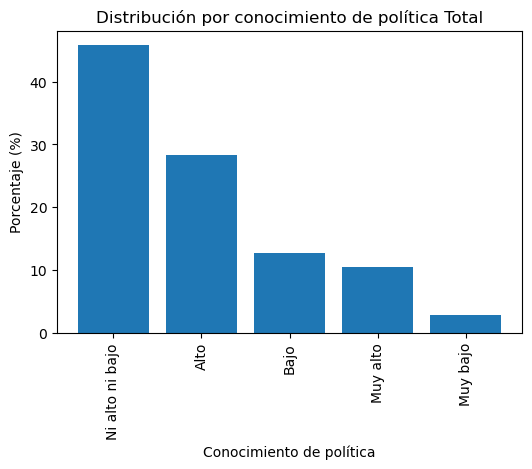

In [54]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('conocim_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Conocimiento de política")
plt.title('Distribución por conocimiento de política Total')
plt.xticks(rotation=90)
plt.show()

In [56]:
from scipy.stats import chi2_contingency

# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([ list(users_per_grade_total.values),list(users_per_grade.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 18.421618652218985
Valor p: 0.0010206022047466355


## Etnicidad

In [57]:
lpop_cohere['etid_label'] = lpop_cohere['etid'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['etid_esp'][x])
lpop['etid_label'] = lpop['etid'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['etid_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\2826530488.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop_cohere['etid_label'] = lpop_cohere['etid'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['etid_esp'][x])
C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_10776\2826530488.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['etid_label'] = lpop['etid'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['etid_esp'][x])


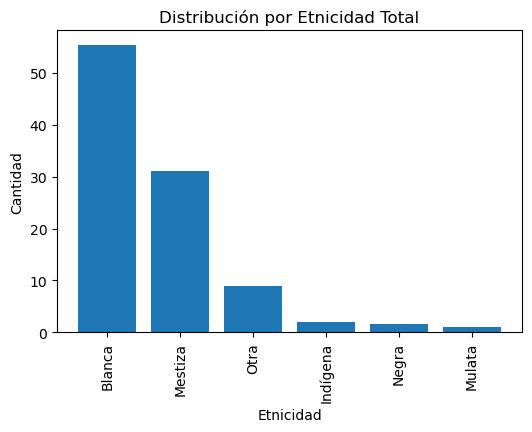

In [58]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('etid_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Etnicidad")
plt.title('Distribución por Etnicidad Total')
plt.xticks(rotation=90)
plt.show()


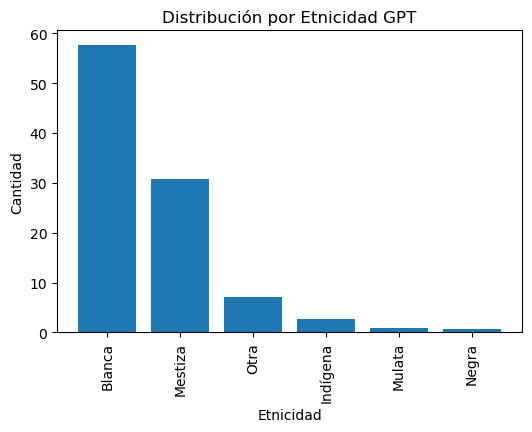

In [59]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_cohere.groupby('etid_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct_gpt = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct_gpt.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Etnicidad")
plt.title('Distribución por Etnicidad GPT')
plt.xticks(rotation=90)
plt.show()


In [60]:
from scipy.stats import chi2_contingency

# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([ list(users_per_grade_total.values),list(users_per_grade_gpt.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 3.1303318979930115
Valor p: 0.6799004978182681


## Diferencias significativas entre quienes opinaron como Cohere y el total

- Edad: Cohere es más joven
- Nivel de estudio
- Conocimiento de politica: Cohere esta mas politizado

## No se diferencian en:

- Etnicidad
- Nivel de ingreso (no pude medirlo)
- Urbanizacion
- Provincia
- Genero

In [7]:
lpop['cohere_distance_norm_wt'] =  lpop['cohere_distance_norm'] * lpop['wt']

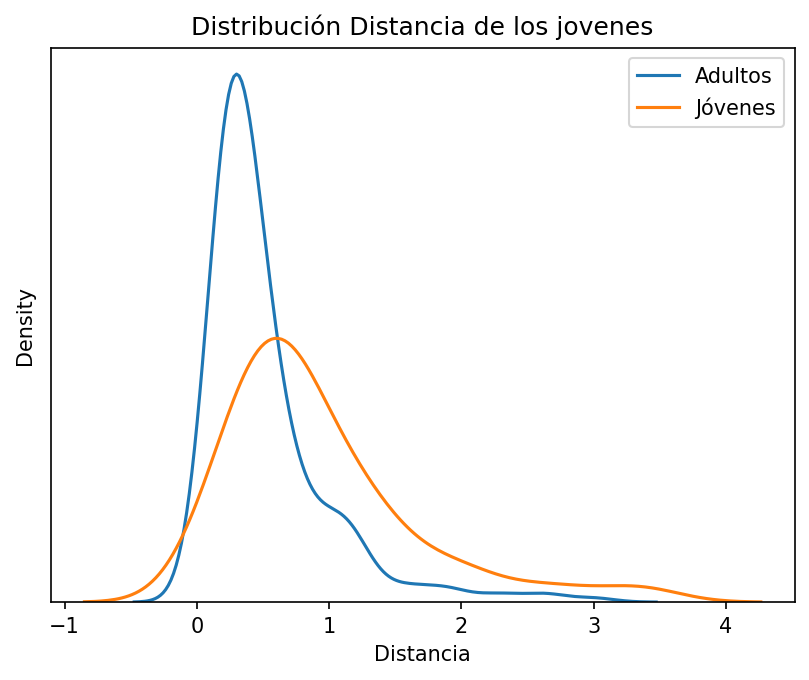

In [9]:
lpop_adulto = lpop[lpop['q2']>40]
lpop_joven = lpop[lpop['q2']<25]
plt.figure(dpi=150)

sns.kdeplot(
   lpop_adulto[lpop_adulto['cohere_num_preg']>8]['cohere_distance_norm_wt'], label="Adultos"
)
sns.kdeplot(
   lpop_joven[lpop_joven['cohere_num_preg']>8]['cohere_distance_norm_wt'], label="Jóvenes"
)
plt.title("Distribución Distancia de los jovenes")
plt.xlabel("Distancia")
plt.yticks([], [])
plt.legend(loc='upper right')
plt.show()

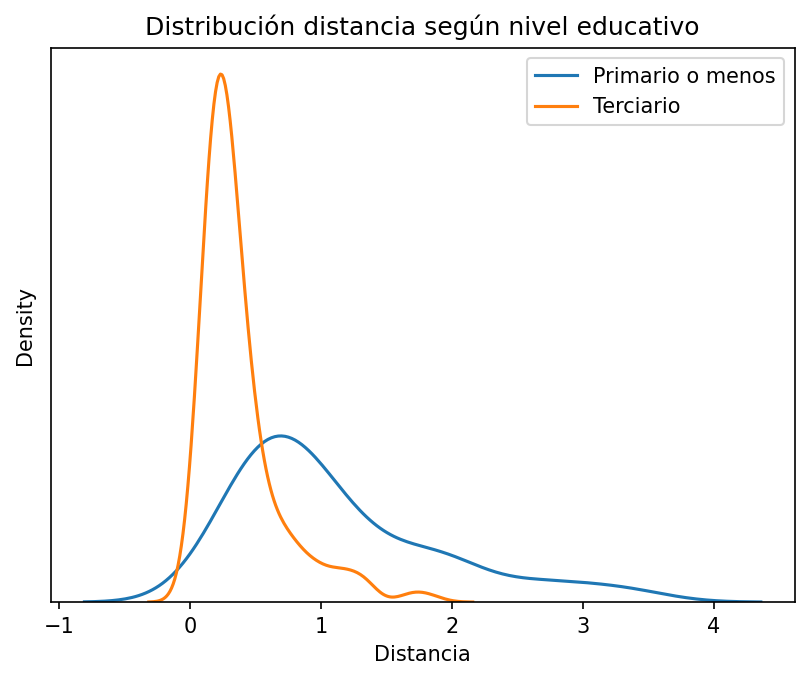

In [10]:
lpop_adulto = lpop[lpop['edr']<=1]
lpop_joven = lpop[lpop['edr']==3]
plt.figure(dpi=150)

sns.kdeplot(
   lpop_adulto[lpop_adulto['cohere_num_preg']>8]['cohere_distance_norm_wt'], label="Primario o menos"
)
sns.kdeplot(
   lpop_joven[lpop_joven['cohere_num_preg']>8]['cohere_distance_norm_wt'], label="Terciario"
)
plt.title("Distribución distancia según nivel educativo")
plt.xlabel("Distancia")
plt.yticks([], [])
plt.legend(loc='upper right')
plt.show()

In [23]:
reader.value_labels()['conocim_esp']

{1: 'Muy alto', 2: 'Alto', 3: 'Ni alto ni bajo', 4: 'Bajo', 5: 'Muy bajo'}

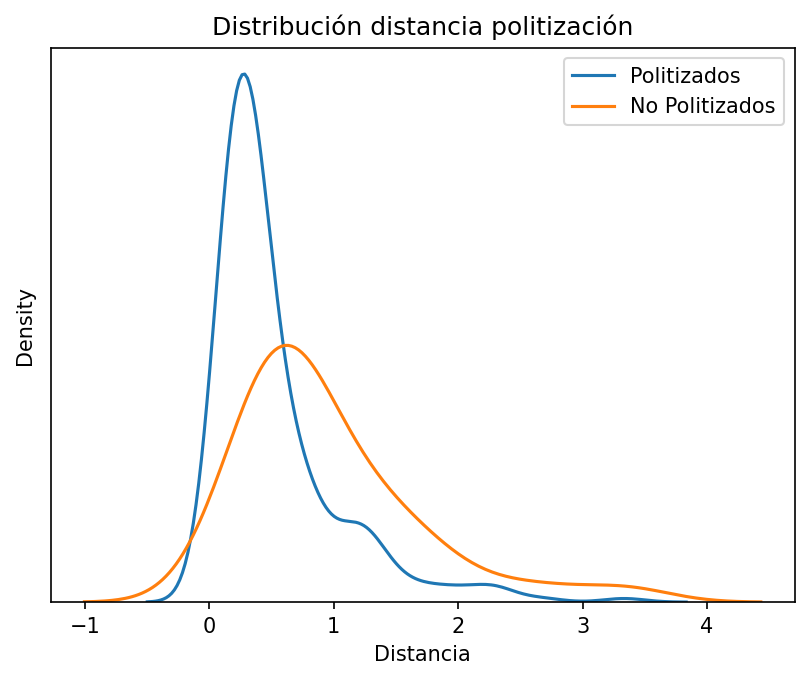

In [11]:
lpop_adulto = lpop[lpop['conocim']<=2]
lpop_joven = lpop[lpop['conocim']>=4]
plt.figure(dpi=150)

sns.kdeplot(
   lpop_adulto[lpop_adulto['cohere_num_preg']>8]['cohere_distance_norm_wt'], label="Politizados"
)
sns.kdeplot(
   lpop_joven[lpop_joven['cohere_num_preg']>8]['cohere_distance_norm_wt'], label="No Politizados"
)
plt.title("Distribución distancia politización")
plt.xlabel("Distancia")
plt.yticks([], [])
plt.legend(loc='upper right')
plt.show()